# Import modules

In [1]:
import tensorflow as tf
import string
import requests
import numpy as np

import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, LSTM, Dropout

# Prepare data

In [2]:
def scrape_text_data():
    response = requests.get(
        "https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt"
    )
    return response

In [3]:
response = scrape_text_data()

In [ ]:
response.text

In [5]:
type(response.text)

str

In this step, we get rid of the `\n` qualifier, and join it using separate lines.

In [6]:
def format_text(response):
    data = response.text.split("\n")[0:]
    data = "".join(data)
    return data

In [8]:
data = format_text(response)

In [9]:
len(data)

5333743

In [ ]:
data

In [11]:
data[1]

'h'

In [12]:
def filter_text(corpus):
    token = corpus.split()
    table = str.maketrans("", "", string.punctuation)
    token = [word.translate(table) for word in token]
    # saving only alphanumeric
    token = [word for word in token if word.isalpha()]
    token = [word.lower() for word in token]
    return token

In [13]:
tokens = filter_text(data)

## Visualize tokens


In [14]:
print(tokens[:20])

['this', 'is', 'the', 'etext', 'file', 'presented', 'by', 'project', 'gutenberg', 'andis', 'presented', 'in', 'cooperation', 'with', 'world', 'library', 'inc', 'from', 'theirlibrary', 'of']


In [15]:
len(tokens)

894651

In [16]:
# calclate vector size from corpus 
len(set(tokens))

29511

In [17]:
def set_seed_length(tokens):
    seed_sequence_length = 50
    lines = []
    for i in range(seed_sequence_length + 1, len(tokens)):
        seq = tokens[i - (seed_sequence_length + 1) : i]
        line = " ".join(seq)
        lines.append(line)
        if i > 2 * 10 ** 5:
            break
    return lines, seed_sequence_length

In [18]:
lines, seed_sequence_length = set_seed_length(tokens)

In [19]:
print(len(lines))

199951


In [20]:
len(lines[0])

359

# Preprocessing 

In [21]:
def vocabulary_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    sequences = tokenizer.texts_to_sequences(lines)
    return sequences, tokenizer

In [ ]:
sequences[1]

In [ ]:
tokenizer.word_index

In [24]:
len(tokenizer.word_index)

13983

In [25]:
vocabulary_length = len(tokenizer.word_index) + 1 #0 indexed

In [26]:
print(len(sequences))

199951


In [27]:
def create_train_test(sequences, vocabulary_length):
    sequences = np.array(sequences)
    X, Y = sequences[:, :-1], sequences[:, -1]
    Y = to_categorical(Y, vocabulary_length)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5)
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [28]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = create_train_test(sequences, vocabulary_length)

# Model

In [29]:
def GRU_model():
    model = Sequential()
    model.add(Embedding(vocabulary_length, 50, input_length=X_train.shape[-1]))
    model.add(
        GRU(
            128,
            dropout=0.2,
            unroll=False,
        )
    )
    model.add(Dense(vocabulary_length, activation="softmax"))
    return model

In [30]:
model = GRU_model()

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            699200    
                                                                 
 gru (GRU)                   (None, 128)               69120     
                                                                 
 dense (Dense)               (None, 13984)             1803936   
                                                                 
Total params: 2,572,256
Trainable params: 2,572,256
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train

In [33]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=100)

Epoch 1/100
2500/2500 [==============================] - 29s 10ms/step - loss: 6.7765 - accuracy: 0.0473
Epoch 2/100
2500/2500 [==============================] - 25s 10ms/step - loss: 6.1642 - accuracy: 0.0826
Epoch 3/100
2500/2500 [==============================] - 25s 10ms/step - loss: 5.8198 - accuracy: 0.1020
Epoch 4/100
2500/2500 [==============================] - 25s 10ms/step - loss: 5.5197 - accuracy: 0.1124
Epoch 5/100
2500/2500 [==============================] - 25s 10ms/step - loss: 5.2489 - accuracy: 0.1220
Epoch 6/100
2500/2500 [==============================] - 25s 10ms/step - loss: 5.0111 - accuracy: 0.1328
Epoch 7/100
2500/2500 [==============================] - 25s 10ms/step - loss: 4.7961 - accuracy: 0.1455
Epoch 8/100
2500/2500 [==============================] - 25s 10ms/step - loss: 4.6113 - accuracy: 0.1608
Epoch 9/100
2500/2500 [==============================] - 25s 10ms/step - loss: 4.4401 - accuracy: 0.1774
Epoch 10/100
2500/2500 [==============================]

In [34]:
def calc_perplexity():
    train_loss = history.history["loss"]
    train_perplexity = tf.exp(train_loss)
    return train_perplexity

In [35]:
def plot_metrics():
    plt.plot(history.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["loss"])

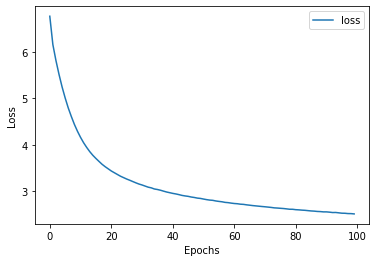

In [36]:
plot_metrics()

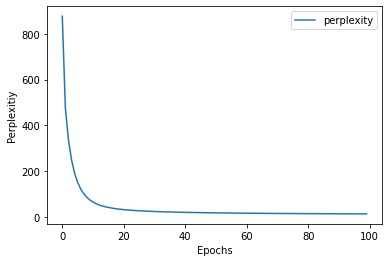

In [37]:
train_perplexity = calc_perplexity()
plt.plot(train_perplexity)
plt.xlabel("Epochs")
plt.ylabel("Perplexitiy")
plt.legend(["perplexity"])

In [38]:
np.max(train_perplexity), np.min(train_perplexity)

(876.9841, 12.249737)

## Text Generation


In [39]:
seed = lines[12343]

In [40]:
print(seed)

strength of all thy state but do not so i love thee in such sort as thou being mine mine is thy good report how like a winter hath my absence been from thee the pleasure of the fleeting year what freezings have i felt what dark days seen what old


In [41]:
def generate_text(model, tokenizer, seed_sequence_length, seed_text, n_words):
    text = []

    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([seed_text])[0]
        encoded = pad_sequences(
            [encoded], maxlen=seed_sequence_length, truncating="pre"
        )

        y_predict = model.predict(encoded)
        y_predict = y_predict.argmax(axis=1)

        predicted_word = ""
        for word, index in tokenizer.word_index.items():

            if index == y_predict:
                predicted_word = word
                break
        seed_text = seed_text + " " + predicted_word
        text.append(predicted_word)
    return " ".join(text)

In [42]:
generate_text(model, tokenizer, seed_sequence_length, seed, 100)

'decembers bareness everywhere and medromio of ephesus i could not die a food to see the world i am weary sir i am not so far i am a strumpet in my mind no more with them i will not say you speak to me with me and so am i born and am right glad nor i have been by day and in their means as i guess at their power i th truth of it i should not say you should not find me not in the aid i suffer not here i dare not till i know'